In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
# from dance_evaluation import *
import matplotlib.pyplot as plt
# from calculate_score import *
from collections import defaultdict

def load_pickle(filepath):
    with open(filepath, "rb") as f:
        json_data = pickle.load(f)
    return json_data

def save_to_pickle(filepath, data):
    # filepath = os.path.join(savepath, filename)
    with open(filepath, "wb") as f:
        pickle.dump(data, f)

## Dance Tempo Score

In [28]:

def compute_dts(
    ref_bpm,
    estimated_bpm,
    tau=0.06,
    mode="one"
):
    """
    Continuous Dance-Tempo Score (DTS), with support for
    either single estimates (mode="one") or multiple
    candidates per frame (mode="many").

    Parameters
    ----------
    ref_bpm : array-like, shape (n,)
        Ground-truth musical tempo in BPM.
    estimated_bpm : 
        If mode="one": array-like, shape (n,)
        If mode="many": iterable of length-n, each element
                        is an iterable of candidate BPMs.
    tau : float, optional
        Tolerance in octaves (0.06 ≈ 4 %).
    mode : {"one", "many"}
        “one”: treat `estimated_bpm` as a flat sequence.
        “many”: pick, for each i, the candidate closest to ref_bpm[i].

    Returns
    -------
    dts : ndarray, shape (n,)
        Scores in [0, 1] (1 = perfect, 0 = miss ≥ τ octaves away).
    e : ndarray, shape (n,)
        Raw octave errors log₂(estimate/ref).
    d : ndarray, shape (n,)
        Wrapped distance to {-1, 0, +1} before clipping.
    """
    ref_bpm = np.asarray(ref_bpm, dtype=float)

    # select a single estimate per index if needed
    if mode == "many":
        chosen = np.array([
            min(cands, key=lambda b: abs(b - ref_bpm[i]))
            for i, cands in enumerate(estimated_bpm)
        ], dtype=float)
    elif mode == "one":
        chosen = np.asarray(estimated_bpm, dtype=float)
    else:
        raise ValueError(f"Unknown mode: {mode!r}. Use 'one' or 'many'.")

    # DTS core ------------------------------------------------------
    e = np.log2(chosen / ref_bpm)
    # distance from nearest of -1, 0, +1
    d = np.abs(e[:, None] - np.array([-1.0, 0.0, 1.0])).min(axis=1)
    # clip by tolerance and convert to score
    d_clip = np.minimum(d, tau)
    dts    = 1.0 - d_clip / tau

    accuracy = (dts > 0.0).mean() * 100
    
    # hits ----------------------------------------------------------
    hit_mask = dts > 0.0          # inside ±tau band
    hit_idx = np.nonzero(hit_mask)[0]
    ref_hit_bpm = ref_bpm[hit_idx]
    
    return dts, e, d, accuracy, hit_idx, ref_hit_bpm


In [31]:
friendly = {
    "adaptv_Bhandfoot_y":  "Both-Hand + Foot (Y)",
    "adaptv_LRfoot_xy":    "L-/R-Foot (XY)",
    "adaptv_LRfoot_res":   "L-/R-Foot (Resultant)",
    "adaptv_LRhand_xy":    "L-/R-Hand (XY)",
    "adaptv_LRhand_res":   "L-/R-Hand (Resultant)",
    "adaptv_Bfoot_x_y":    "Both-Foot (X & Y)",
    "adaptv_Bhandfoot_x":  "Both-Hand & Both-Foot (X)",
    "adaptv_Bhand_x_y":    "Both-Hand (X & Y)",
    "adaptv_Bhandfoot_res":"Both-Hand & Both-Foot (Resultant)",
}

def estimate_tempo_posvel(a, b, mode, w_sec, h_sec):
    # Using both zero velocity and peak velocity
    segment_pairs = [
        "adaptv_Bhandfoot_y",
        "adaptv_Bhandfoot_x",
        "adaptv_LRhand_xy",
        "adaptv_LRfoot_xy",
        "adaptv_Bhand_x_y",
        "adaptv_Bfoot_x_y"]
    

    
    score_data = {}
    json_data = {}
    # oPath = f"./saved_result/tttempo_{a}_{b}/"
    root = "/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result"
    pth_pos = f"{root}/tttempo_{a}_{b}/pos"
    pth_vel = f"{root}/tttempo_{a}_{b}/vel"
    
    bpm_dict = ["bpm_avg",  "bpm_mode", "bpm_median"]
    for bpm_mode in bpm_dict:
        score_data[bpm_mode] = {}
        json_data[bpm_mode] = {}
        for seg in segment_pairs:
            fpath_pos = os.path.join(pth_pos, f"{seg}_zero_uni_W5_H2.5_25_140.pkl")
            fpath_vel = os.path.join(pth_vel, f"{seg}_zero_uni_W5_H2.5_25_140.pkl")
            
            df1 = load_pickle(fpath_pos)
            df2 = load_pickle(fpath_vel)

            # Build candidate BPM pairs 
            bpm_pos = []
            bpm_vel = []
            bpm_posvel = []
            for n in range(df1.shape[0]):
                bpm1 = df1.iloc[n][bpm_mode]   # hand (position)
                bpm2 = df2.iloc[n][bpm_mode]   # foot (position)
                # bpm3 = df3.iloc[n][bpm_mode]   # hand (velocity)
                # bpm4 = df4.iloc[n][bpm_mode]   # foot (velocity)
                
                # bpm_pos.append((bpm1, bpm2))
                # bpm_vel.append((bpm3, bpm4))
                bpm_posvel.append((bpm1, bpm2))
            
            # music_tempo from df1 
            ref = df1["music_tempo"].to_numpy()
            
            _, _, _, dts_acc3, hit_idx, ref_hit_bpm = compute_dts(ref, bpm_posvel, tau=0.10, mode = "many")
            
            score_data[bpm_mode][friendly[seg]] = {"acc": dts_acc3, "hit_idx": hit_idx, "ref_hit_bpm": ref_hit_bpm}
            
            json_data[bpm_mode][seg] = {"bpm_pos": bpm_pos,
                                             "bpm_vel": bpm_vel,
                                            "bpm_posvel": bpm_posvel,
                                            "Acc1_bpm_pos": 5,
                                            "Acc1_bpm_vel": 5,
                                            "Acc1_bpm_posvel": dts_acc3,}
            
    
    #### Sace the score data to a pickle file
    save_dir = f"./saved_result/tttempo_{a}_{b}/score"
    fname1 = f"score_multi_adap_posvel_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
    fpath1 = os.path.join(save_dir, fname1)
    save_to_pickle(fpath1, score_data)
        
    return json_data

estimate_tempo_posvel(25, 140, "zero_uni", 5, 5/2)

{'bpm_avg': {'adaptv_Bhandfoot_y': {'bpm_pos': [],
   'bpm_vel': [],
   'bpm_posvel': [(112.5, 114.75),
    (136.0, 127.0),
    (104.0, 106.0),
    (93.75, 106.5),
    (102.5, 119.75),
    (134.67, 135.33),
    (93.59, 79.0),
    (104.25, 100.75),
    (98.6, 130.6),
    (100.8, 117.8),
    (111.75, 112.25),
    (119.0, 126.4),
    (117.67, 124.33),
    (128.33, 128.67),
    (131.0, 130.33),
    (103.0, 137.25),
    (91.0, 89.4),
    (111.6, 88.0),
    (78.75, 134.5),
    (92.0, 92.8),
    (59.75, 120.25),
    (123.5, 124.0),
    (127.33, 117.33),
    (113.75, 113.0),
    (109.25, 132.0),
    (118.6, 112.8),
    (82.4, 79.6),
    (128.67, 132.33),
    (109.4, 99.4),
    (122.0, 131.25),
    (119.5, 120.0),
    (68.3, 71.15),
    (98.0, 97.5),
    (111.0, 89.95),
    (130.67, 130.33),
    (102.4, 104.2),
    (121.25, 127.25),
    (98.6, 114.0),
    (93.8, 95.4),
    (117.33, 116.67),
    (100.0, 92.0),
    (122.75, 127.0),
    (129.33, 129.67),
    (119.25, 114.5),
    (110.75, 112.75),


### For adaptive weighting

In [32]:
from collections import defaultdict

# path setup
a, b = 25, 140
root = "/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result"
pth_pos = f"{root}/tttempo_{a}_{b}/pos"
pth_vel = f"{root}/tttempo_{a}_{b}/vel"

# descriptive labels for plot axis
friendly = {
    "adaptv_Bhandfoot_y":  "Both-Hand + Foot (Y)",
    "adaptv_LRfoot_xy":    "L-/R-Foot (XY)",
    "adaptv_LRfoot_res":   "L-/R-Foot (Resultant)",
    "adaptv_LRhand_xy":    "L-/R-Hand (XY)",
    "adaptv_LRhand_res":   "L-/R-Hand (Resultant)",
    "adaptv_Bfoot_x_y":    "Both-Foot (X & Y)",
    "adaptv_Bhandfoot_x":  "Both-Hand & Both-Foot (X)",
    "adaptv_Bhand_x_y":    "Both-Hand (X & Y)",
    "adaptv_Bhandfoot_res":"Both-Hand & Both-Foot (Resultant)",
}

# helper to compute accuracy and fill a dictionary
def collect_accuracies(folder, metric):
    acc = {}
    score_data = {"bpm_median": {}, "bpm_avg": {}, "bpm_mode": {}}
    for fname in os.listdir(folder):
        
        tag = fname.split("_zero_uni")[0]
        data = load_pickle(f"{folder}/{fname}")
        ref  = data["music_tempo"].to_numpy()
        _, _, _, accuracy, hit_idx, ref_hit_bpm = compute_dts(ref, data["bpm_median"].to_numpy(),
                                            tau=0.10, mode="one")
        acc[friendly[tag]] = round(accuracy, 2)
        
        score_data["bpm_median"][friendly[tag]] = {"acc": accuracy, "hit_idx": hit_idx, "ref_hit_bpm": ref_hit_bpm}
        
    # save the score data
    save_dir = f"./saved_result/tttempo_{a}_{b}/score"
    fname1 = f"score_multi_adap_{metric}_zero_uni_W5_H2.5_25_140.pkl"
    fpath1 = os.path.join(save_dir, fname1)
    save_to_pickle(fpath1, score_data)
    
    return acc

# build two dicts, one for pos and one for vel, ready for bar plotting
accuracy_dict_pos = collect_accuracies(pth_pos, "pos")
accuracy_dict_vel = collect_accuracies(pth_vel, "vel")

# optional: merge if you prefer a single dictionary
# accuracy_dict = {**accuracy_dict_pos, **accuracy_dict_vel}


In [27]:
accuracy_dict_vel

{'Both-Hand + Foot (Y)': 58.02,
 'L-/R-Foot (XY)': 35.5,
 'L-/R-Foot (Resultant)': 0.0,
 'L-/R-Hand (XY)': 45.19,
 'L-/R-Hand (Resultant)': 0.0,
 'Both-Foot (X & Y)': 43.33,
 'Both-Hand & Both-Foot (X)': 26.25,
 'Both-Hand (X & Y)': 48.77,
 'Both-Hand & Both-Foot (Resultant)': 0.0}

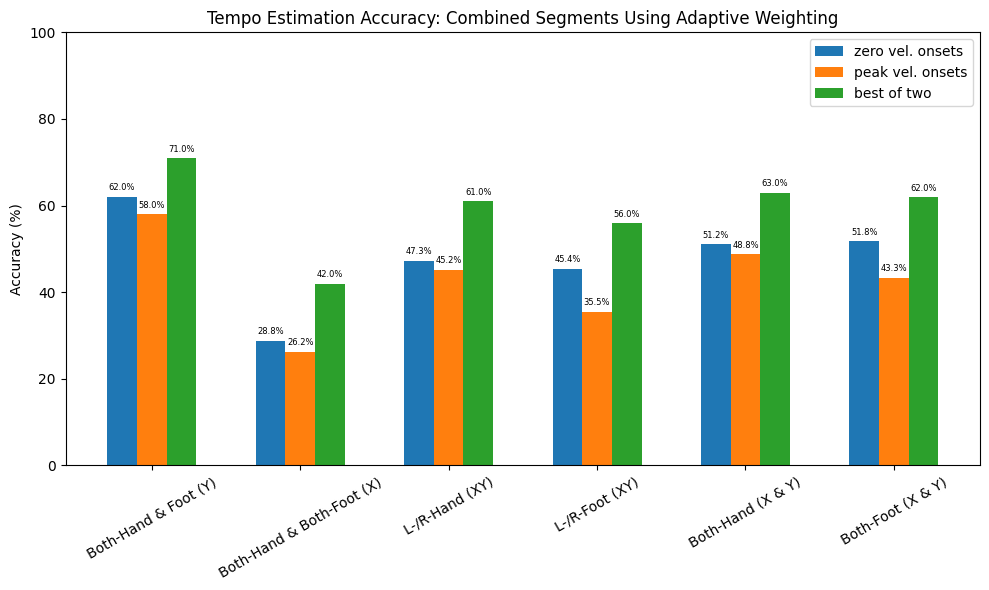

In [16]:
import numpy as np
import matplotlib.pyplot as plt

accuracy_pos = {
    'Both-Hand & Foot (Y)': 62.04,
    'Both-Hand & Both-Foot (X)': 28.78,
    'L-/R-Hand (XY)': 47.28,
    'L-/R-Foot (XY)': 45.41,
    'Both-Hand (X & Y)': 51.16,
    'Both-Foot (X & Y)': 51.83,
}

accuracy_vel = {
    'Both-Hand & Foot (Y)': 58.02,
    'Both-Hand & Both-Foot (X)': 26.25,
    'L-/R-Hand (XY)': 45.19,
    'L-/R-Foot (XY)': 35.5,
    'Both-Hand (X & Y)': 48.77,
    'Both-Foot (X & Y)': 43.33,
}

best_of_two = {
    'Both-Hand & Foot (Y)': 71,
    'Both-Hand & Both-Foot (X)': 42,
    'L-/R-Hand (XY)': 61,
    'L-/R-Foot (XY)': 56,
    'Both-Hand (X & Y)': 63,
    'Both-Foot (X & Y)': 62,
}

labels   = list(accuracy_pos.keys())
pos_vals = [accuracy_pos[k] for k in labels]
vel_vals = [accuracy_vel[k] for k in labels]
best_vals= [best_of_two[k]   for k in labels]

x         = np.arange(len(labels))
bar_width = 0.2

plt.figure(figsize=(10, 6))

bars_pos  = plt.bar(x - bar_width,      pos_vals,  bar_width, label='zero vel. onsets', color='tab:blue')
bars_vel  = plt.bar(x,                  vel_vals,  bar_width, label='peak vel. onsets', color='tab:orange')
bars_best = plt.bar(x + bar_width,      best_vals, bar_width, label='best of two',       color='tab:green')

plt.xticks(x, labels, rotation=30, ha='center')
plt.ylabel('Accuracy (%)')
plt.title('Tempo Estimation Accuracy: Combined Segments Using Adaptive Weighting')
plt.ylim(0, 100)

# Annotate
for bar in bars_pos + bars_vel + bars_best:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h + 1,
        f'{h:.1f}%',
        ha='center', va='bottom',
        fontsize=6
    )

plt.legend()
plt.tight_layout()
plt.show()


### Bar Plot: Both Hand+Foot (Multi Score)

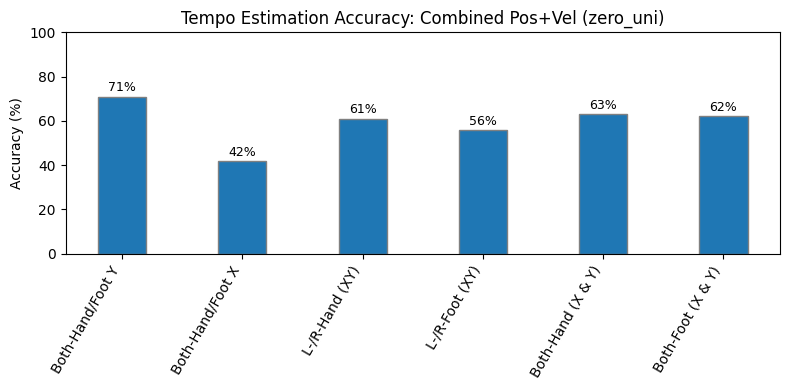

In [7]:

# Define your segments and descriptive labels
segments_3 = [
    "adaptv_Bhandfoot_y",
    "adaptv_Bhandfoot_x",
    "adaptv_LRhand_xy",
    "adaptv_LRfoot_xy",
    "adaptv_Bhand_x_y",
    "adaptv_Bfoot_x_y",
]

labels = [
    'Both-Hand/Foot Y',
    'Both-Hand/Foot X',
    'L-/R-Hand (XY)',
    'L-/R-Foot (XY)',
    'Both-Hand (X & Y)',
    'Both-Foot (X & Y)',
]

# Parameters
a, b       = 25, 140
mode       = "zero_uni"
w_sec, h_sec = 5, 5/2

# Compute only the combined posvel accuracy
t_data = estimate_tempo_posvel(a, b, mode, w_sec, h_sec)
accuracies_posvel = [
    round(t_data['bpm_median'][seg]['Acc1_bpm_posvel'])
    for seg in segments_3
]

# Plotting
x = np.arange(len(labels))
bar_width = 0.4


plt.figure(figsize=(8, 4), dpi=100)
bars = plt.bar(
    x,
    accuracies_posvel,
    width=bar_width,
    color= 'tab:blue',
    edgecolor='gray',
    # label='PosVel'
)

plt.xticks(x, labels, rotation=60, ha='right')
plt.ylabel('Accuracy (%)')
plt.title('Tempo Estimation Accuracy: Combined Pos+Vel (zero_uni)')
plt.ylim(0, 100)
# plt.legend()

# Annotate bars
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h + 1,
        f'{h}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [8]:
accuracies_posvel

[71, 42, 61, 56, 63, 62]

### 4 bpm: Not included in the paper

In [36]:
def estimate_tempo_posvel_4bpm(a, b, mode, w_sec, h_sec):
    # Using both zero velocity and peak velocity
    segment_pairs = [
        ("adaptv_Bhandfoot_y", "adaptv_Bhandfoot_x"),
        ("adaptv_LRhand_xy", "adaptv_LRfoot_xy"),
        ("adaptv_Bhand_x_y", "adaptv_Bfoot_x_y")]
    

    
    score_data = {}
    json_data = {}
    # oPath = f"./saved_result/tttempo_{a}_{b}/"
    root = "/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result"
    pth_pos = f"{root}/tttempo_{a}_{b}/pos"
    pth_vel = f"{root}/tttempo_{a}_{b}/vel"
    
    bpm_dict = ["bpm_avg",  "bpm_mode", "bpm_median"]
    for bpm_mode in bpm_dict:
        score_data[bpm_mode] = {}
        json_data[bpm_mode] = {}
        
        for seg1, seg2 in segment_pairs:
            fpath_pos1 = os.path.join(pth_pos, f"{seg1}_zero_uni_W5_H2.5_25_140.pkl")
            fpath_vel2 = os.path.join(pth_vel, f"{seg2}_zero_uni_W5_H2.5_25_140.pkl")
            fpath_pos3 = os.path.join(pth_pos, f"{seg2}_zero_uni_W5_H2.5_25_140.pkl")
            fpath_vel4 = os.path.join(pth_vel, f"{seg1}_zero_uni_W5_H2.5_25_140.pkl")
            
            
            df1 = load_pickle(fpath_pos1)   # pos seg1
            df4 = load_pickle(fpath_vel4)   # vel seg1
            
            df3 = load_pickle(fpath_pos3)   # pos seg2
            df2 = load_pickle(fpath_vel2)   # vel seg2
            
            
            # Build candidate BPM pairs (for positions) and quads (for positions and velocities)
            bpm_pos = []
            bpm_vel = []
            bpm_posvel = []
            for n in range(df1.shape[0]):
                bpm1 = df1.iloc[n][bpm_mode]   
                bpm2 = df2.iloc[n][bpm_mode]   
                bpm3 = df3.iloc[n][bpm_mode]   
                bpm4 = df4.iloc[n][bpm_mode]   
                
                bpm_pos.append((bpm1, bpm4))    # seg1 pos + vel
                bpm_vel.append((bpm3, bpm2))    # seg2 pos + vel
                bpm_posvel.append((bpm1, bpm2, bpm3, bpm4))   # seg1 pos + seg2 pos + seg1 vel + seg2 vel
            
            # music_tempo from df1 
            ref = df1["music_tempo"].to_numpy()
            
            _, _, _, dts_acc1 = compute_dts(ref, bpm_pos, tau=0.10, mode = "many")
            _, _, _, dts_acc2 = compute_dts(ref, bpm_vel, tau=0.10, mode = "many")
            _, _, _, dts_acc3 = compute_dts(ref, bpm_posvel, tau=0.10, mode = "many")
            
            json_data[bpm_mode][seg1+seg2] = {"bpm_pos": bpm_pos,
                                             "bpm_vel": bpm_vel,
                                            "bpm_posvel": bpm_posvel,
                                            "Acc1_bpm_pos": dts_acc1,
                                            "Acc1_bpm_vel": dts_acc2,
                                            "Acc1_bpm_posvel": dts_acc3,}
            
    return json_data

    
    #### Sace the score data to a pickle file
    # save_dir = f"./saved_result/tempo_{a}_{b}/score"
    # fname1 = f"score_multi_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
    # fpath1 = os.path.join(save_dir, fname1)
    # save_to_pickle(fpath1, score_data)
        

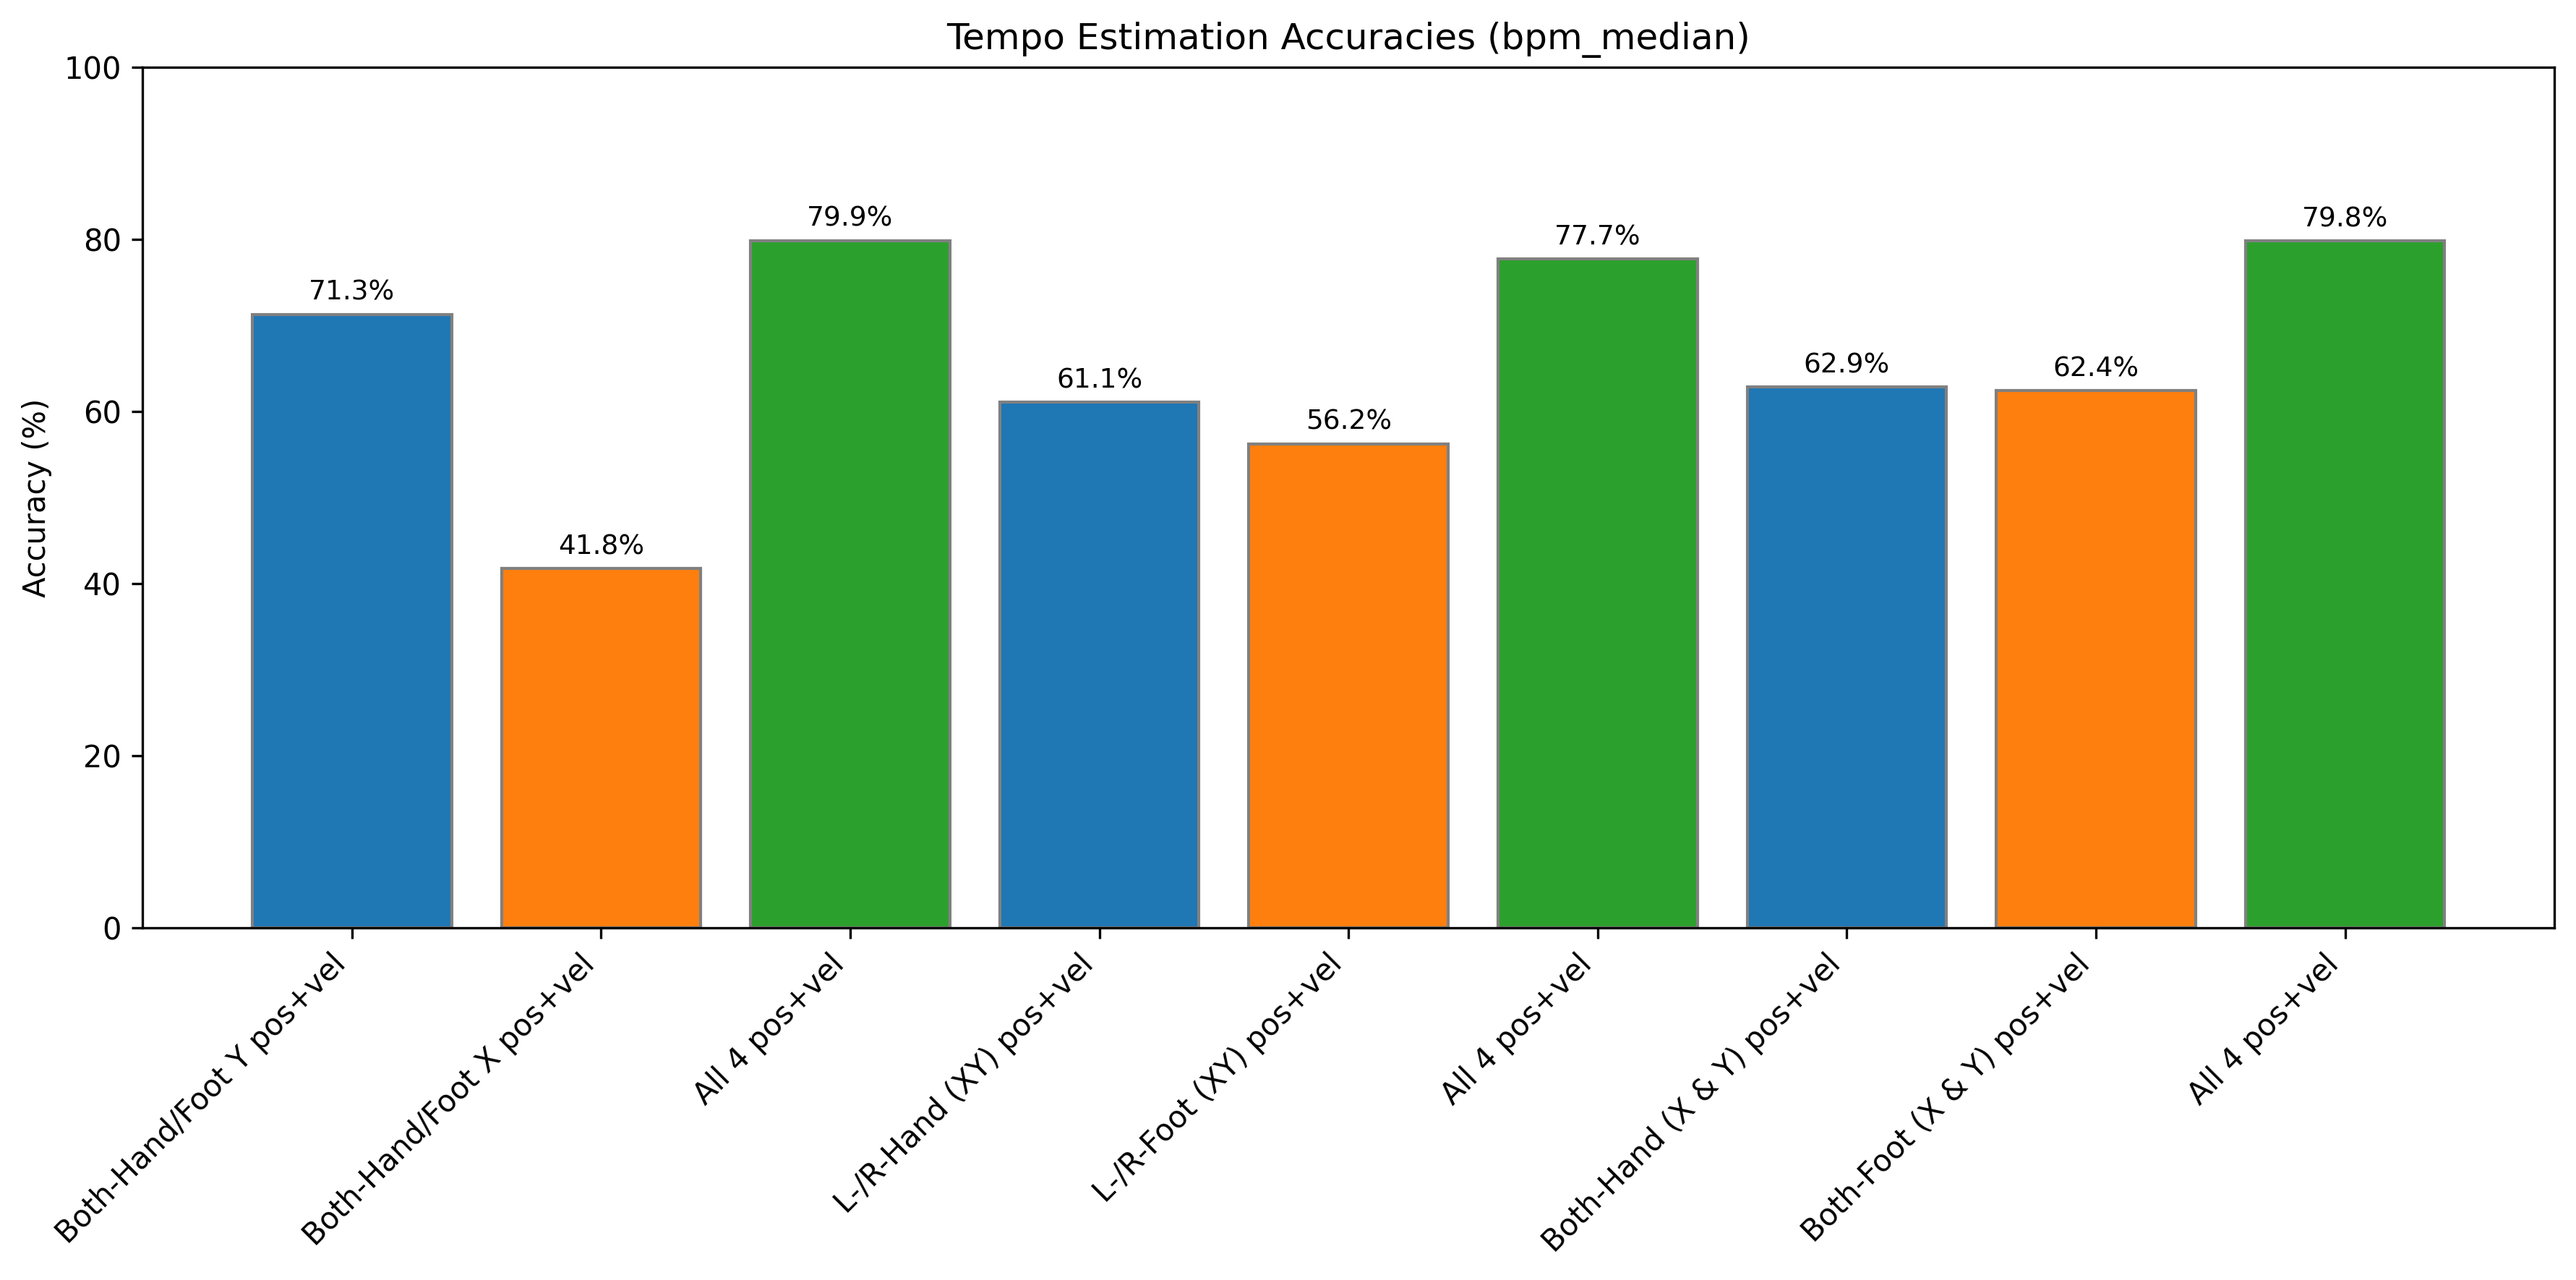

In [ ]:

# Parameters and data
a, b         = 25, 140
mode         = "zero_uni"
w_sec, h_sec = 5, 5/2
bpm_mode     = "bpm_median"
json_data    = estimate_tempo_posvel_4bpm(a, b, mode, w_sec, h_sec)
data         = json_data[bpm_mode]

# Segment pairs and friendly names
segment_pairs = [
    ("adaptv_Bhandfoot_y", "adaptv_Bhandfoot_x"),
    ("adaptv_LRhand_xy",   "adaptv_LRfoot_xy"),
    ("adaptv_Bhand_x_y",   "adaptv_Bfoot_x_y"),
]
friendly = {
    "adaptv_Bhandfoot_y":  'Both-Hand/Foot Y',
    "adaptv_Bhandfoot_x":  'Both-Hand/Foot X',
    "adaptv_LRhand_xy":    'L-/R-Hand (XY)',
    "adaptv_LRfoot_xy":    'L-/R-Foot (XY)',
    "adaptv_Bhand_x_y":    'Both-Hand (X & Y)',
    "adaptv_Bfoot_x_y":    'Both-Foot (X & Y)',
}


# Collect and flatten accuracies and labels
acc_flat = []
labels_flat = []
colors = []
color_cycle = ['tab:blue', 'tab:orange', 'tab:green']

for i, (seg1, seg2) in enumerate(segment_pairs):
    entry = data[seg1 + seg2]
    acc1 = round(np.mean(entry["Acc1_bpm_pos"]),    2)  # seg1 pos+vel
    acc2 = round(np.mean(entry["Acc1_bpm_vel"]),    2)  # seg2 pos+vel
    acc3 = round(np.mean(entry["Acc1_bpm_posvel"]), 2)  # all 4 pos+vel

    acc_flat.extend([acc1, acc2, acc3])
    labels_flat.extend([
        f"{friendly[seg1]} pos+vel",
        f"{friendly[seg2]} pos+vel",
        "All 4 pos+vel"
    ])
    # assign colors per bar: [blue, orange, green] repeating
    colors.extend(color_cycle)

# Plot
x = np.arange(len(acc_flat))
bar_w = 0.8

plt.figure(figsize=(12, 6), dpi=100)
bars = plt.bar(x, acc_flat, bar_w, color=colors, edgecolor='gray')

plt.xticks(x, labels_flat, rotation=45, ha='right')
plt.ylabel("Accuracy (%)")
plt.title(f"Tempo Estimation Accuracies ({bpm_mode})")
plt.ylim(0, 100)

# Annotate
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h + 1,
        f"{h:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


### Dance Tempo Score

In [3]:
# segment_keys = [
#                 "left_hand_x", "right_hand_x", "left_hand_y", "right_hand_y",   # singular
#                 "left_foot_x", "right_foot_x", "left_foot_y", "right_foot_y",   # singular
                
#                 "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
#                 "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                
#                 "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
#                     "both_hand_resultant", "both_foot_resultant", # resultant of x and y onsets
#                 ]

a = 25; b= 140
metric = "pos"
mode = "zero_uni"
w_sec = 5; h_sec = w_sec/2

score_data = {}
json_data = {}
# bpm_dict = ["bpm_avg",  "bpm_mode", "bpm_median"]
oPath = f"./saved_result/tempo_{a}_{b}/"

f_name = "both_hand_y"
bpm_mode = "bpm_median"


f_path = oPath + f"{metric}/{f_name}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
df_ax = pd.read_pickle(f_path)

ref_bpm = df_ax["music_tempo"].to_numpy()
estimated_bpm = df_ax[bpm_mode].to_numpy()

In [4]:
genre = {
    "Break": "gBR",
    "Pop": "gPO",
    "Lock": "gLO",
    "Middle Hip-hop": "gMH",
    "LA style Hip-hop": "gLH",
    "House": "gHO",
    "Waack": "gWA",
    "Krump": "gKR",
    "Street Jazz": "gJS",
    "Ballet Jazz": "gJB"
}



df_genre = df_ax[df_ax["dance_genre"] == genre["Middle Hip-hop"]]
ref_bpm = df_genre["music_tempo"].to_numpy()
estimated_bpm = df_genre[bpm_mode].to_numpy()

In [5]:
def compute_dts(ref_bpm, estimated_bpm, tau=0.06):
    """
    Continuous Dance‑Tempo Score (DTS).

    Parameters
    ----------
    ref_bpm : 1‑D array-like
        Ground‑truth musical tempo in BPM.
    estimated_bpm : 1‑D array-like
        Estimated dancer tempo in BPM.
    tau : float, optional
        Tolerance in octaves (0.06 ≈ 4 %).

    Returns
    -------
    dts : ndarray
        Scores in [0, 1] (1 = perfect, 0 = miss ≥ τ octaves away).
    e   : ndarray
        Raw octave errors log2(estimated/ref).
    d   : ndarray
        Wrapped distance to {‑1, 0, +1} before clipping.
    """
    ref_bpm       = np.asarray(ref_bpm, dtype=float)
    estimated_bpm = np.asarray(estimated_bpm, dtype=float)

    # log‑octave error
    e = np.log2(estimated_bpm / ref_bpm)

    # distance to nearest of {‑1, 0, +1}
    d = np.abs(e[:, None] - np.array([-1.0, 0.0, 1.0])).min(axis=1)

    # clip by tolerance and convert to score
    d_clip = np.minimum(d, tau)
    dts    = 1.0 - d_clip / tau
    return dts, e, d




In [ ]:
for key in genre.keys():
    df_genre = df_ax[df_ax["dance_genre"] == genre[key]]
    ref_bpm = df_genre["music_tempo"].to_numpy()
    estimated_bpm = df_genre[bpm_mode].to_numpy()
    tau=0.10
    dts, e, d = compute_dts(ref_bpm, estimated_bpm, tau=tau)
    
    print(f"tau: {tau}")
    print(f"Genre: {key}")
    print(f"Mean DTS          : {dts.mean():.3f}")
    print(f"Median DTS        : {np.median(dts):.3f}")
    print(f"Accuracy DTS ≥0.30: {(dts >= 0.1).mean() * 100:.2f}%")
    print("\n")

tau: 0.2
Mean DTS          : 0.421
Median DTS        : 0.411
Accuracy DTS ≥0.80: 56.00%


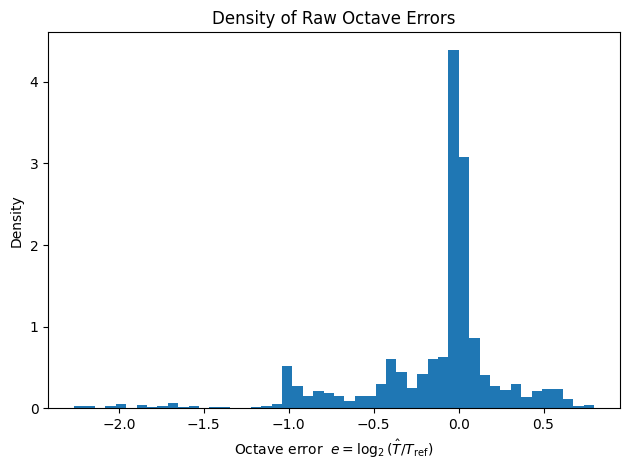

In [10]:
# ------------------------------------------------------------------

# df_genre = df_ax[df_ax["dance_genre"] == genre["Middle Hip-hop"]]
# ref_bpm = df_genre["music_tempo"].to_numpy()
# estimated_bpm = df_genre[bpm_mode].to_numpy()


ref_bpm = df_ax["music_tempo"].to_numpy()
estimated_bpm = df_ax[bpm_mode].to_numpy()

### adaptive ###
# bhf  = load_pickle("/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result/tttempo_60_140/pos/bhf_zero_uni_W5_H2.5_60_140.pkl")
# ref_bpm = bhf["music_tempo"].to_numpy()
# estimated_bpm = np.asarray(bhf["bpm_median"], dtype=float)

dts, e, d = compute_dts(ref_bpm, estimated_bpm, tau=0.10)

print(f"tau: 0.2")
print(f"Mean DTS          : {dts.mean():.3f}")
print(f"Median DTS        : {np.median(dts):.3f}")
print(f"Accuracy DTS ≥0.80: {(dts > 0.1).mean() * 100:.2f}%")

# ------------------------------------------------------------------
# Visualise the score distribution ---------------------------------
# plt.figure()
# plt.hist(dts, bins=30)
# plt.xlabel("Dance‑Tempo Score (DTS)")
# plt.ylabel("Count")
# plt.title("Distribution of DTS")
# plt.tight_layout()
# plt.show()

plt.figure()
plt.hist(e, bins=50, density=True)
plt.xlabel("Octave error  $e = \\log_2(\\hat{T}/T_{\\mathrm{ref}})$")
plt.ylabel("Density")
plt.title("Density of Raw Octave Errors")
plt.tight_layout()

In [19]:
import numpy as np

def percent_band(tau):
    """
    Compute p(τ) = (2^τ − 1) × 100%
    
    Args:
      tau: scalar or array of octave widths
    Returns:
      p: same shape as tau, percent band
    """
    return (2**tau - 1) * 100

def bpm_band(T_ref, tau):
    """
    Given reference BPM T_ref and octave width tau,
    return (BPM_min, BPM_max) of the symmetric τ-band.
    """
    p = percent_band(tau) / 100.0
    return T_ref * (1 - p), T_ref * (1 + p)

# Example usage:
if __name__ == "__main__":
    # your example taus
    taus = np.array([0.06, 0.10, 0.20])
    T_ref = 120.0  # example reference BPM
    
    # compute percent bands
    p_vals = percent_band(taus)
    print(p_vals)
    # compute rule-of-thumb linear approximation for small tau
    # rule_of_thumb = 69.3 * taus  # percent
    
    # print table header
    # print(f"{'τ (oct)':>7} | {'p(τ) [%]':>8} | {'≈ rule-of-thumb [%]':>18}")
    # print("-"*40)
    
    # print rows
    # for τ, p, rot in zip(taus, p_vals, rule_of_thumb):
    #     print(f"{τ:7.2f} | {p:8.1f} | {rot:18.1f}")
    
    print("\nExample BPM bands (T_ref = {:.1f}):".format(T_ref))
    for τ in taus:
        lo, hi = bpm_band(T_ref, τ)
        print(f"  τ = {τ:.2f} → [{lo:.1f}, {hi:.1f}] BPM")


[ 4.24657608  7.17734625 14.8698355 ]

Example BPM bands (T_ref = 120.0):
  τ = 0.06 → [114.9, 125.1] BPM
  τ = 0.10 → [111.4, 128.6] BPM
  τ = 0.20 → [102.2, 137.8] BPM
